# Pipeline for testing models on MTS

## Introduction
This notebook is meant to be a draft for different **VAE** (Variational Autoencoder) struktures to test them on generated **MTS** (Multivariate Time Series) with varying complexity.    
It uses the **dataGen** class to simulate some artificial manufakturing Data, where all the parameters and effects (Seasonalities, Trends, Couling and Anomalies) can be controlled.   
The **Encoders** and **Decoders** classes contain the different encoding, decoding blocks to form the vae, **vae** uses combines them together to form vae.   
**train** class contains the functions to train and test the models. All other functions for plotting the results and experimenting with the Latent Representation are stored in **utils**.  

In [1]:
%load_ext autoreload
%autoreload 2
from dataGen import Gen
from utils import compare, experiment, extract_parameters, suppress_prints, add_mu_std
from train import slidingWindow, criterion, train, test, objective, train_vae
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer

import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.distributions as D
from torch.utils.data import DataLoader
import optuna
from optuna.samplers import TPESampler
import torchaudio


import numpy as np
import matplotlib.pyplot as plt
import pprint

## Generating the fake data

Here we specify all the parameters for the data generation.   
It is important to note that all the parameters control the shape of the data but the **MTS** is generated randomly with respect to these inputs. The actual paramters ($\mu$ and $\gamma$ at each point, indexes and values of each effect etc...) are stored in the **params** and **e_params** attributes of the class.
### Channels
- **Periode:** The number of days to simulate.
- **Step:** How many minutes between each Measurement.
- **Val:** The maximum Value possible in y-axis.
- **n_channels:** The number of channels to simulate.   

### Effects
All Effect but the **Noise** are applied on the mean and std level (internal) and not on the final values.
- **Pulse:** Can be a point or a rectangular pulse over an interval.
- **Trend:** Is basically a shift in one of the channels, can be linear or quadratic.
- **Seasonality:** Adds a sinusiudal fluctuation on a channel, the frequency here is 'how many oscillations per week'.
- **Std_variation:** Changes the std over an interval .
- **Channel_Coupling** Adds a coupling between two channels over the whole Simulation. If active, the Cov Matrix will have non-zero values beside the diagonal.
- **Noise:** Adds some noise on the generated values to simulate measurement noise &rarr; $y_{noise} = y +\epsilon $.

{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [-1.1056255427924313,
                         -0.2589978767446419,
                         0.836186424791979,
                         0.2517040969610278,
                         -0.9521056910939552],
           'channel': [8, 6, 4, 3, 0],
           'index': ['2023-03-01T19:55:00',
                     '2023-03-09T11:35:00',
                     '2023-03-08T07:10:00',
                     '2023-03-12T20:40:00',
                     '2023-03-12T22:15:00']},
 'Seasonality': {'amplitude': [18, 11, 11],
                 'channel': [8, 2, 6],
                 'frequency_per_week': [13.187555356928303,
                                        9.278581464825741,
                                        8.155111284034039],
                 'phaseshift': [85, 150, 11]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [6

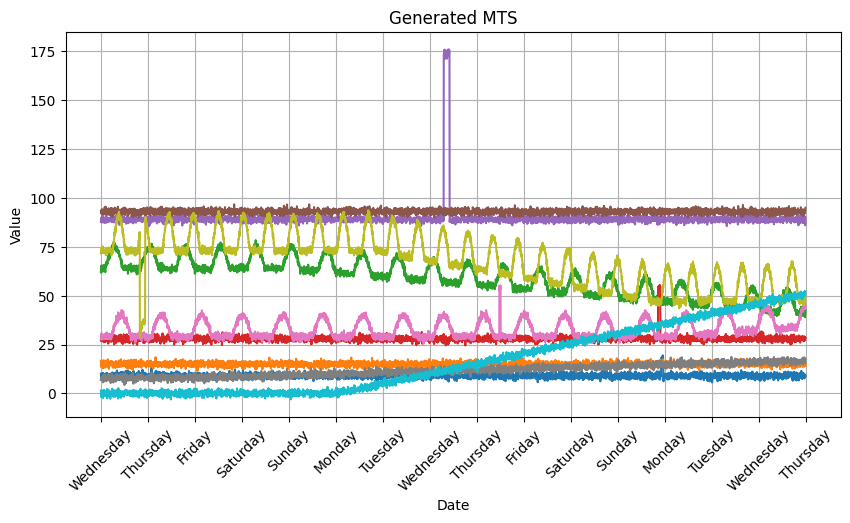

In [2]:
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 100
n_channels = 10
effects = {
    "Pulse": {
        "occurances":5,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":6,
        "max_slope":0.005,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":3,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

In [3]:
x = torch.FloatTensor(x)
x

tensor([[23.1218, 24.3056, 21.5028,  ..., 42.5112, 42.8860, 44.0675]])

In [4]:
import torch
import torchaudio.transforms as transforms

# Create a random tensor of shape (1, 16000)
waveform = torch.randn(1, 16000)
print(waveform)

# Define the MelSpectrogram transformation
mel_spectrogram = transforms.MelSpectrogram(sample_rate=500, n_fft=244, hop_length=1, n_mels=128)

# Apply the MelSpectrogram transformation to the waveform tensor
mel_spec = mel_spectrogram(x)

tensor([[ 1.2853,  0.2951,  0.2448,  ..., -0.1656, -2.0723, -0.9368]])


In [5]:
import torchaudio.transforms as T
import torch.nn.functional as F

# # Load the time series data into a PyTorch tensor
x = torch.FloatTensor(x)# = torch.tensor(np.loadtxt('your_time_series_file.txt'))
x_normalized = F.normalize(x, p=2, dim=1)
print(x.shape)
# Create a transform to compute the Mel spectrogram
# n_fft = 2048
# hop_length = 44100  # 1 sample per few minutes
# mel_spec_transform = T.MelSpectrogram(sample_rate=1, n_fft=n_fft, hop_length=hop_length, n_mels=128)

# Create a transform to compute the Mel spectrogram
n_fft = 2048
hop_length = 44100  # 1 sample per few minutes
mel_spec_transform = T.MelSpectrogram(sample_rate=1000, n_fft=512, hop_length=20)
#     mel_spec_transform = T.MelSpectrogram(sample_rate=1, n_fft=n_fft, hop_length=hop_length, n_mels=128, onesided=True)
# Compute the Mel spectrogram of the time series data
mel_spec = mel_spec_transform(x_normalized)

# Convert the Mel spectrogram to a log-scale
log_mel_spec = T.AmplitudeToDB()(mel_spec)

# Create a transform to compute the MFCCs from the log Mel spectrogram
mfcc_transform = T.MFCC(n_mfcc=20)

# Compute the MFCCs from the log Mel spectrogram
mfcc = mfcc_transform(log_mel_spec)
# utils.plot_spectrogram(mfcc[0], title="MFCC")

torch.Size([1, 4320])


/home/kadran1/testenv/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
4320/

In [155]:
log_mel_spec

tensor([[[ 6.7809e+00,  6.7821e+00,  6.8112e+00,  ...,  5.9219e+00,
           6.1725e+00,  6.2491e+00],
         [-4.3113e+00, -4.3852e+00, -4.5764e+00,  ..., -3.4450e+00,
          -3.3918e+00, -3.3589e+00],
         [ 2.6270e-02, -2.5423e-02, -1.6843e-01,  ..., -4.0220e+00,
          -4.6029e+00, -4.7959e+00],
         ...,
         [-3.3411e+01, -3.3506e+01, -3.3789e+01,  ..., -3.0205e+01,
          -3.0540e+01, -3.0664e+01],
         [-3.5377e+01, -3.5326e+01, -3.5182e+01,  ..., -3.0680e+01,
          -3.0758e+01, -3.0777e+01],
         [-3.0807e+01, -3.0592e+01, -3.0038e+01,  ..., -2.9728e+01,
          -3.0109e+01, -3.0251e+01]]])

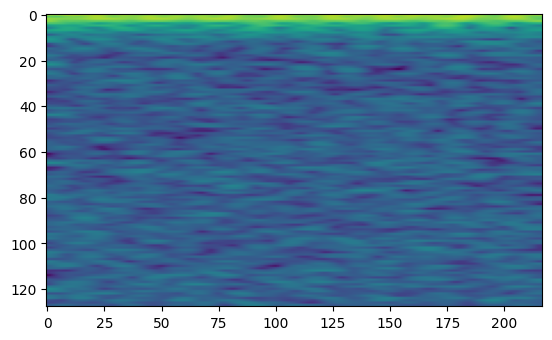

In [156]:
plt.imshow(log_mel_spec[0])

## Model Init
The **vae** and **optimizer** are initialized in this cell.  
- **input_size** is the number of channels.
- **hidden_size** is the number of Neurons in the hidden size of the last MLP layer of the **Encoder** (to generate the $\mu$ and $\sigma$).
- **num_layer** is the number of layers in the main Structure (TCN or RNN for now).
- **latent_dims** is the number of variables in the Latent Representation.
- **v_encoder** which Encoder to use from the **Encoders** class.
- **v_decoder** which Encoder to use from the **Decoders** class.
- **L** is the window length.
- **slope** is the slope value for the LeakyRelu activation (if they are used).
- **first_kernel** is only relevant for the LongShort_TCVAE and specifies the Kernel length of the first conv layer in the long TCN.

In [6]:
### Init Model
latent_dims = 10
L=24*12
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# v = vae(n_channels, L, latent_dims)
# v = VariationalAutoencoder(input_size = n_channels,
#                       hidden_size = 30,
#                       num_layers = 3,
#                       latent_dims= latent_dims,
#                       v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder, # RnnEncoder, LongShort_TCVAE_Encoder,
#                       v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder, # RnnDecoder, LongShort_TCVAE_Decoder,
#                       L = L,
#                       slope = 0.2,
#                       first_kernel = 21)
v = VQ_MST_VAE(n_channels = n_channels,
                            num_layers = 3,
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = 0.2,
                            first_kernel = 15,
                            commit_loss = 10)
enc = MST_VAE_Encoder_dist(     n_channels,
                           num_layers = 3,
                           slope = 0.2,
                           first_kernel = 15)
dec = MST_VAE_Decoder_dist(     n_channels,
                           num_layers = 3,
                           slope = 0.2,
                           first_kernel = 15)


v = v.to(device)
enc = enc.to(device)
dec = dec.to(device)
opt = optim.Adam(v.parameters(), lr = 0.001571)
# print(v)

## Split and Dataloader
This cell is for splitting the Data and creating a Dataloader for each set. The dataloaders will return the data using an overlapping sliding window over the time axis.

In [8]:
# Create the dictionaries of probability distributions
# pnet = {'z': D.Normal(loc=torch.zeros(latent_dims), scale=torch.ones(latent_dims)), 'x': dec}
# qnet = {'z': enc}
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]
# L = 30

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=100,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=100,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

## Training 
The data is trained using the train class for 100 epochs. A hyperparameter optimisation can be also run (needs gpu)

In [9]:
for epoch in range(1, 50):
    train(v, train_data, criterion, opt, device, epoch, VQ = True)
# test(v, test_data, criterion, device)

torch.Size([100, 1, 288])
torch.Size([100, 2, 144])
torch.Size([100, 2, 144])
torch.Size([100, 2, 144])
torch.Size([100, 4, 72])
torch.Size([100, 4, 72])
torch.Size([100, 4, 72])
torch.Size([100, 6, 36])
torch.Size([100, 6, 36])
torch.Size([100, 216])
torch.Size([100, 10])
torch.Size([100, 1, 10])
torch.Size([100, 1, 288])
torch.Size([100, 2, 137])
torch.Size([100, 2, 137])
torch.Size([100, 2, 137])
torch.Size([100, 4, 68])
torch.Size([100, 4, 68])
torch.Size([100, 4, 68])
torch.Size([100, 6, 34])
torch.Size([100, 6, 34])
torch.Size([100, 204])
torch.Size([100, 10])
torch.Size([100, 1, 10])
Short Encoder mu:  torch.Size([100, 1, 10])
Long Encoder mu:  torch.Size([100, 1, 10])
After Cat:  torch.Size([100, 2, 10])
Decoder Input  torch.Size([100, 2, 10])


RuntimeError: shape '[100, 2, 1]' is invalid for input of size 2000

In [9]:
v.quantizer._embedding.weight.size()

torch.Size([1, 10])

In [10]:
torch.save(v.state_dict(), r'modules/vq_vae.pt')

RuntimeError: Parent directory modules does not exist.

In [74]:
train_vae(train_data, enc, dec, opt, device, 100)

ValueError: Expected parameter covariance_matrix (Tensor of shape (10, 3, 3)) of distribution MultivariateNormal(loc: torch.Size([10, 3]), covariance_matrix: torch.Size([10, 3, 3])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[1.3728, 1.0000, 1.0000],
         [1.0000, 0.8775, 1.0000],
         [1.0000, 1.0000, 0.9979]],

        [[1.4724, 1.0000, 1.0000],
         [1.0000, 1.0651, 1.0000],
         [1.0000, 1.0000, 0.9107]],

        [[1.1715, 1.0000, 1.0000],
         [1.0000, 1.1071, 1.0000],
         [1.0000, 1.0000, 1.1622]],

        [[1.1694, 1.0000, 1.0000],
         [1.0000, 1.1007, 1.0000],
         [1.0000, 1.0000, 1.5582]],

        [[1.1575, 1.0000, 1.0000],
         [1.0000, 1.0837, 1.0000],
         [1.0000, 1.0000, 1.0644]],

        [[0.8748, 1.0000, 1.0000],
         [1.0000, 1.3120, 1.0000],
         [1.0000, 1.0000, 2.7183]],

        [[1.1429, 1.0000, 1.0000],
         [1.0000, 1.1378, 1.0000],
         [1.0000, 1.0000, 1.3114]],

        [[0.7416, 1.0000, 1.0000],
         [1.0000, 1.2056, 1.0000],
         [1.0000, 1.0000, 2.1711]],

        [[1.2234, 1.0000, 1.0000],
         [1.0000, 1.0814, 1.0000],
         [1.0000, 1.0000, 1.0776]],

        [[1.0813, 1.0000, 1.0000],
         [1.0000, 1.2631, 1.0000],
         [1.0000, 1.0000, 2.2147]]], device='cuda:0',
       grad_fn=<ExpandBackward0>)

In [7]:
# Define the Optuna study and optimize the hyperparameters
epochs = 30
study = optuna.create_study(sampler=TPESampler(), direction='minimize')
study.optimize(lambda trial: objective(trial,
                                       VariationalAutoencoder,
                                       train_data, 
                                       test_data, 
                                       criterion, 
                                       train, 
                                       test, 
                                       n_channels,
                                       L, epochs
                                      ),
               n_trials=10)

[I 2023-03-29 23:51:56,783] A new study created in memory with name: no-name-3c15745b-1daf-4c87-9fdf-4299897d6904


Train Epoch: 1 [0/3396 (0%)]	Loss: 5714.675781
Train Epoch: 1 [1000/3396 (29%)]	Loss: 93.452576
Train Epoch: 1 [2000/3396 (59%)]	Loss: 111.563513
Train Epoch: 1 [3000/3396 (88%)]	Loss: 164.488965
====> Epoch: 1 Average loss: 519.3952
Train Epoch: 2 [0/3396 (0%)]	Loss: 101.482672
Train Epoch: 2 [1000/3396 (29%)]	Loss: 41.055939
Train Epoch: 2 [2000/3396 (59%)]	Loss: 116.973657
Train Epoch: 2 [3000/3396 (88%)]	Loss: 737.954199
====> Epoch: 2 Average loss: 3904.9542
Train Epoch: 3 [0/3396 (0%)]	Loss: 782.400781
Train Epoch: 3 [1000/3396 (29%)]	Loss: 3182.169531
Train Epoch: 3 [2000/3396 (59%)]	Loss: 813.013086
Train Epoch: 3 [3000/3396 (88%)]	Loss: 1322.235059
====> Epoch: 3 Average loss: 6765.6253
Train Epoch: 4 [0/3396 (0%)]	Loss: 990.111035
Train Epoch: 4 [1000/3396 (29%)]	Loss: 990.433203
Train Epoch: 4 [2000/3396 (59%)]	Loss: 1093.223633
Train Epoch: 4 [3000/3396 (88%)]	Loss: 1290.422266
====> Epoch: 4 Average loss: 1187.9142
Train Epoch: 5 [0/3396 (0%)]	Loss: 965.231445
Train Epoch:

[W 2023-03-29 23:53:07,441] Trial 0 failed with parameters: {'learning_rate': 0.068136170005768, 'num_layers': 3, 'latent_dims': 4, 'first_kernel': 23, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-29 23:53:07,442] Trial 0 failed with value nan.


====> Epoch: 29 Average loss: 2227.0529
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5728.923828
Train Epoch: 1 [1000/3396 (29%)]	Loss: 80.873053
Train Epoch: 1 [2000/3396 (59%)]	Loss: 81.908984
Train Epoch: 1 [3000/3396 (88%)]	Loss: 58.404059
====> Epoch: 1 Average loss: 439.2469
Train Epoch: 2 [0/3396 (0%)]	Loss: 62.733246
Train Epoch: 2 [1000/3396 (29%)]	Loss: 166.464368
Train Epoch: 2 [2000/3396 (59%)]	Loss: 132.910071
Train Epoch: 2 [3000/3396 (88%)]	Loss: 90.132324
====> Epoch: 2 Average loss: 117.6371
Train Epoch: 3 [0/3396 (0%)]	Loss: 26.399704
Train Epoch: 3 [1000/3396 (29%)]	Loss: 36.980597
Train Epoch: 3 [2000/3396 (59%)]	Loss: 50.036456
Train Epoch: 3 [3000/3396 (88%)]	Loss: 62.723712
====> Epoch: 3 Average loss: 86.8458
Train Epoch: 4 [0/3396 (0%)]	Loss: 23.264452
Train Epoch: 4 [1000/3396 (29%)]	Loss: 22.870560
Train Epoch: 4 [2000/3396 (59%)]	Loss: 145.016113
Train Epoch: 4 [3000/3396 (88%)]	Loss: 36.923334
====> Epoch: 4 Average loss: 76.1910
Train Ep

[W 2023-03-29 23:54:14,566] Trial 1 failed with parameters: {'learning_rate': 0.03808970968317062, 'num_layers': 3, 'latent_dims': 8, 'first_kernel': 17, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-29 23:54:14,567] Trial 1 failed with value nan.


====> Epoch: 29 Average loss: 297.5342
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5697.216406
Train Epoch: 1 [1000/3396 (29%)]	Loss: 32.307599
Train Epoch: 1 [2000/3396 (59%)]	Loss: 65.985754
Train Epoch: 1 [3000/3396 (88%)]	Loss: 55.425842
====> Epoch: 1 Average loss: 678.5702
Train Epoch: 2 [0/3396 (0%)]	Loss: 34.911499
Train Epoch: 2 [1000/3396 (29%)]	Loss: 52.498303
Train Epoch: 2 [2000/3396 (59%)]	Loss: 144.303979
Train Epoch: 2 [3000/3396 (88%)]	Loss: 57.782147
====> Epoch: 2 Average loss: 66.0066
Train Epoch: 3 [0/3396 (0%)]	Loss: 38.517517
Train Epoch: 3 [1000/3396 (29%)]	Loss: 81.843225
Train Epoch: 3 [2000/3396 (59%)]	Loss: 40.144730
Train Epoch: 3 [3000/3396 (88%)]	Loss: 33.157516
====> Epoch: 3 Average loss: 54.7307
Train Epoch: 4 [0/3396 (0%)]	Loss: 24.878958
Train Epoch: 4 [1000/3396 (29%)]	Loss: 65.859143
Train Epoch: 4 [2000/3396 (59%)]	Loss: 43.049295
Train Epoch: 4 [3000/3396 (88%)]	Loss: 51.965515
====> Epoch: 4 Average loss: 48.9950
Train Epoch:

[W 2023-03-29 23:55:19,350] Trial 2 failed with parameters: {'learning_rate': 0.018036480958651117, 'num_layers': 3, 'latent_dims': 7, 'first_kernel': 22, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-29 23:55:19,351] Trial 2 failed with value nan.


====> Epoch: 29 Average loss: 29.4438
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5727.318750
Train Epoch: 1 [1000/3396 (29%)]	Loss: 4835.281641
Train Epoch: 1 [2000/3396 (59%)]	Loss: 2920.721484
Train Epoch: 1 [3000/3396 (88%)]	Loss: 3362.061719
====> Epoch: 1 Average loss: 3857.3651
Train Epoch: 2 [0/3396 (0%)]	Loss: 2552.368555
Train Epoch: 2 [1000/3396 (29%)]	Loss: 1738.549219
Train Epoch: 2 [2000/3396 (59%)]	Loss: 659.560840
Train Epoch: 2 [3000/3396 (88%)]	Loss: 884.741895
====> Epoch: 2 Average loss: 1258.8380
Train Epoch: 3 [0/3396 (0%)]	Loss: 511.235205
Train Epoch: 3 [1000/3396 (29%)]	Loss: 243.625537
Train Epoch: 3 [2000/3396 (59%)]	Loss: 36.693918
Train Epoch: 3 [3000/3396 (88%)]	Loss: 186.020435
====> Epoch: 3 Average loss: 195.9000
Train Epoch: 4 [0/3396 (0%)]	Loss: 79.519550
Train Epoch: 4 [1000/3396 (29%)]	Loss: 32.260449
Train Epoch: 4 [2000/3396 (59%)]	Loss: 54.765265
Train Epoch: 4 [3000/3396 (88%)]	Loss: 83.449860
====> Epoch: 4 Average loss: 74.

[I 2023-03-29 23:56:45,686] Trial 3 finished with value: 845.3286162755822 and parameters: {'learning_rate': 0.0014276189422675776, 'num_layers': 4, 'latent_dims': 4, 'first_kernel': 20, 'slope': 0}. Best is trial 3 with value: 845.3286162755822.


====> Epoch: 29 Average loss: 23.2920
====> Test set loss: 845.3286
845.3286162755822
Train Epoch: 1 [0/3396 (0%)]	Loss: 5701.336328
Train Epoch: 1 [1000/3396 (29%)]	Loss: 284.489136
Train Epoch: 1 [2000/3396 (59%)]	Loss: 405.717822
Train Epoch: 1 [3000/3396 (88%)]	Loss: 441.372461
====> Epoch: 1 Average loss: 722.6623
Train Epoch: 2 [0/3396 (0%)]	Loss: 369.826172
Train Epoch: 2 [1000/3396 (29%)]	Loss: 245.651318
Train Epoch: 2 [2000/3396 (59%)]	Loss: 105.283521
Train Epoch: 2 [3000/3396 (88%)]	Loss: 227.262012
====> Epoch: 2 Average loss: 211.8285
Train Epoch: 3 [0/3396 (0%)]	Loss: 59.662537
Train Epoch: 3 [1000/3396 (29%)]	Loss: 23.177577
Train Epoch: 3 [2000/3396 (59%)]	Loss: 67.451483
Train Epoch: 3 [3000/3396 (88%)]	Loss: 115.219592
====> Epoch: 3 Average loss: 94.5640
Train Epoch: 4 [0/3396 (0%)]	Loss: 36.304453
Train Epoch: 4 [1000/3396 (29%)]	Loss: 17.306808
Train Epoch: 4 [2000/3396 (59%)]	Loss: 61.902979
Train Epoch: 4 [3000/3396 (88%)]	Loss: 86.066327
====> Epoch: 4 Average 

[W 2023-03-29 23:57:58,152] Trial 4 failed with parameters: {'learning_rate': 0.0380723617813375, 'num_layers': 3, 'latent_dims': 7, 'first_kernel': 23, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-29 23:57:58,153] Trial 4 failed with value nan.


====> Epoch: 29 Average loss: 94438.4187
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5696.181250
Train Epoch: 1 [1000/3396 (29%)]	Loss: 41.264316
Train Epoch: 1 [2000/3396 (59%)]	Loss: 115.255322
Train Epoch: 1 [3000/3396 (88%)]	Loss: 190.639160
====> Epoch: 1 Average loss: 444.2742
Train Epoch: 2 [0/3396 (0%)]	Loss: 27.323636
Train Epoch: 2 [1000/3396 (29%)]	Loss: 31.721179
Train Epoch: 2 [2000/3396 (59%)]	Loss: 81.510107
Train Epoch: 2 [3000/3396 (88%)]	Loss: 42.881076
====> Epoch: 2 Average loss: 85.6867
Train Epoch: 3 [0/3396 (0%)]	Loss: 98.895581
Train Epoch: 3 [1000/3396 (29%)]	Loss: 49.226550
Train Epoch: 3 [2000/3396 (59%)]	Loss: 108.365112
Train Epoch: 3 [3000/3396 (88%)]	Loss: 58.745831
====> Epoch: 3 Average loss: 90.1840
Train Epoch: 4 [0/3396 (0%)]	Loss: 137.025854
Train Epoch: 4 [1000/3396 (29%)]	Loss: 35.369373
Train Epoch: 4 [2000/3396 (59%)]	Loss: 60.417578
Train Epoch: 4 [3000/3396 (88%)]	Loss: 33.089471
====> Epoch: 4 Average loss: 70.9828
Train E

[W 2023-03-29 23:59:05,548] Trial 5 failed with parameters: {'learning_rate': 0.04118559454621497, 'num_layers': 3, 'latent_dims': 4, 'first_kernel': 30, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-29 23:59:05,549] Trial 5 failed with value nan.


====> Epoch: 29 Average loss: 527.2256
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5693.452344
Train Epoch: 1 [1000/3396 (29%)]	Loss: 1233.028418
Train Epoch: 1 [2000/3396 (59%)]	Loss: 50.837375
Train Epoch: 1 [3000/3396 (88%)]	Loss: 89.459320
====> Epoch: 1 Average loss: 1111.3250
Train Epoch: 2 [0/3396 (0%)]	Loss: 33.005237
Train Epoch: 2 [1000/3396 (29%)]	Loss: 21.668843
Train Epoch: 2 [2000/3396 (59%)]	Loss: 68.310376
Train Epoch: 2 [3000/3396 (88%)]	Loss: 88.732385
====> Epoch: 2 Average loss: 77.1108
Train Epoch: 3 [0/3396 (0%)]	Loss: 29.588000
Train Epoch: 3 [1000/3396 (29%)]	Loss: 21.298848
Train Epoch: 3 [2000/3396 (59%)]	Loss: 66.970392
Train Epoch: 3 [3000/3396 (88%)]	Loss: 184.412476
====> Epoch: 3 Average loss: 78.3448
Train Epoch: 4 [0/3396 (0%)]	Loss: 30.603741
Train Epoch: 4 [1000/3396 (29%)]	Loss: 23.327968
Train Epoch: 4 [2000/3396 (59%)]	Loss: 397.514014
Train Epoch: 4 [3000/3396 (88%)]	Loss: 120.107202
====> Epoch: 4 Average loss: 88.5260
Train E

[W 2023-03-30 00:00:30,283] Trial 6 failed with parameters: {'learning_rate': 0.007626288584169327, 'num_layers': 4, 'latent_dims': 5, 'first_kernel': 23, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-30 00:00:30,284] Trial 6 failed with value nan.


====> Epoch: 29 Average loss: 26.1857
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5733.599609
Train Epoch: 1 [1000/3396 (29%)]	Loss: 309.060669
Train Epoch: 1 [2000/3396 (59%)]	Loss: 379.467920
Train Epoch: 1 [3000/3396 (88%)]	Loss: 583.893164
====> Epoch: 1 Average loss: 501.0863
Train Epoch: 2 [0/3396 (0%)]	Loss: 299.802905
Train Epoch: 2 [1000/3396 (29%)]	Loss: 306.021606
Train Epoch: 2 [2000/3396 (59%)]	Loss: 367.487744
Train Epoch: 2 [3000/3396 (88%)]	Loss: 664.490332
====> Epoch: 2 Average loss: 279.5946
Train Epoch: 3 [0/3396 (0%)]	Loss: 353.852563
Train Epoch: 3 [1000/3396 (29%)]	Loss: 248.435449
Train Epoch: 3 [2000/3396 (59%)]	Loss: 341.475342
Train Epoch: 3 [3000/3396 (88%)]	Loss: 1276.737402
====> Epoch: 3 Average loss: 2085.2852
Train Epoch: 4 [0/3396 (0%)]	Loss: 11059.186719
Train Epoch: 4 [1000/3396 (29%)]	Loss: 37284.593750
Train Epoch: 4 [2000/3396 (59%)]	Loss: 38347.525000
Train Epoch: 4 [3000/3396 (88%)]	Loss: 4189.217578
====> Epoch: 4 Average lo

[W 2023-03-30 00:01:36,334] Trial 7 failed with parameters: {'learning_rate': 0.09221426873493353, 'num_layers': 3, 'latent_dims': 5, 'first_kernel': 24, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-30 00:01:36,335] Trial 7 failed with value nan.


====> Epoch: 29 Average loss: nan
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5724.851953
Train Epoch: 1 [1000/3396 (29%)]	Loss: 63.909808
Train Epoch: 1 [2000/3396 (59%)]	Loss: 124.383313
Train Epoch: 1 [3000/3396 (88%)]	Loss: 201.955798
====> Epoch: 1 Average loss: 377.7929
Train Epoch: 2 [0/3396 (0%)]	Loss: 82.833374
Train Epoch: 2 [1000/3396 (29%)]	Loss: 177.568848
Train Epoch: 2 [2000/3396 (59%)]	Loss: 219.126099
Train Epoch: 2 [3000/3396 (88%)]	Loss: 227.804492
====> Epoch: 2 Average loss: 160.5449
Train Epoch: 3 [0/3396 (0%)]	Loss: 50.644571
Train Epoch: 3 [1000/3396 (29%)]	Loss: 163.533618
Train Epoch: 3 [2000/3396 (59%)]	Loss: 913.659668
Train Epoch: 3 [3000/3396 (88%)]	Loss: 8772.978125
====> Epoch: 3 Average loss: 1344722.7869
Train Epoch: 4 [0/3396 (0%)]	Loss: 9281.973438
Train Epoch: 4 [1000/3396 (29%)]	Loss: 3788.484766
Train Epoch: 4 [2000/3396 (59%)]	Loss: 3596.419531
Train Epoch: 4 [3000/3396 (88%)]	Loss: 3662.772266
====> Epoch: 4 Average loss: 193

[W 2023-03-30 00:02:40,382] Trial 8 failed with parameters: {'learning_rate': 0.08327419636383393, 'num_layers': 3, 'latent_dims': 10, 'first_kernel': 20, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-30 00:02:40,383] Trial 8 failed with value nan.


====> Epoch: 29 Average loss: 4701.7666
====> Test set loss: nan
nan
Train Epoch: 1 [0/3396 (0%)]	Loss: 5746.482031
Train Epoch: 1 [1000/3396 (29%)]	Loss: 74.790546
Train Epoch: 1 [2000/3396 (59%)]	Loss: 136.287866
Train Epoch: 1 [3000/3396 (88%)]	Loss: 314.617871
====> Epoch: 1 Average loss: 347.8609
Train Epoch: 2 [0/3396 (0%)]	Loss: 118.801660
Train Epoch: 2 [1000/3396 (29%)]	Loss: 37.767307
Train Epoch: 2 [2000/3396 (59%)]	Loss: 140.817822
Train Epoch: 2 [3000/3396 (88%)]	Loss: 287.218896
====> Epoch: 2 Average loss: 185.2688
Train Epoch: 3 [0/3396 (0%)]	Loss: 112.503003
Train Epoch: 3 [1000/3396 (29%)]	Loss: 32.944199
Train Epoch: 3 [2000/3396 (59%)]	Loss: 134.854529
Train Epoch: 3 [3000/3396 (88%)]	Loss: 281.032300
====> Epoch: 3 Average loss: 180.3411
Train Epoch: 4 [0/3396 (0%)]	Loss: 109.930920
Train Epoch: 4 [1000/3396 (29%)]	Loss: 31.017029
Train Epoch: 4 [2000/3396 (59%)]	Loss: 131.262805
Train Epoch: 4 [3000/3396 (88%)]	Loss: 272.618994
====> Epoch: 4 Average loss: 175.857

[W 2023-03-30 00:04:27,079] Trial 9 failed with parameters: {'learning_rate': 0.08624711475600887, 'num_layers': 5, 'latent_dims': 6, 'first_kernel': 15, 'slope': 0} because of the following error: The value nan is not acceptable..
[W 2023-03-30 00:04:27,080] Trial 9 failed with value nan.


====> Epoch: 29 Average loss: 1137.4127
====> Test set loss: nan
nan


## Plot and Experiment
**compare** function plots the <span style="color:blue">Original Data</span> vs <span style="color:red">Reconstruction </span>.
**experiment** generates 2 interactive plots.
- **Left** is the same plot generated by compare (<span style="color:blue">Original Data</span> vs <span style="color:red">Reconstruction </span>)
- **Right** are the Latent Variables **Z** over time.   
The Sliders on the bottom control the values of each $z$ to see the effect it has on the reconstruction. both plots react to the change of $z$ values.

VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequential(
        (0): Linear(in_features=216, out_features=10, bias=True)
      )
      (encoder_logvar): Sequential(
        (0): Linear(in_features=216, out_features=10, bias=True)
      )
    )
    (long_encoder): TCVAE_Encoder(
 

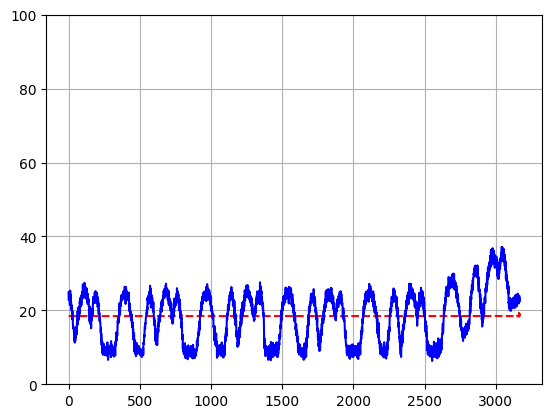

In [6]:
v.cpu()
compare(train_data, v, VQ=True)
v.to(device)

In [17]:
compare(test_data, v)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

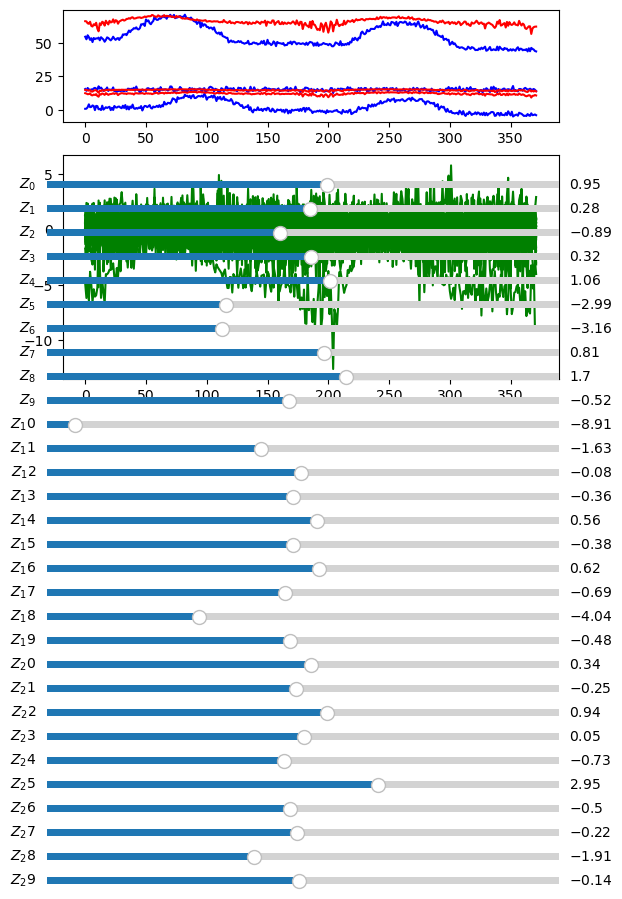

In [9]:
experiment(test_data, v)

In [49]:
Pulse = torch.empty(3,0)
Trend = torch.empty(3,0)
Seasonality = torch.empty(4,0)
Std_variation = torch.empty(3,0)
Channels_Coupling = torch.empty(3,0)
Noise = torch.empty(3,0)
effs =[Pulse, Trend, Seasonality, Std_variation, Channels_Coupling, Noise]
reference_time = np.datetime64('2023-03-01T00:00:00')

for (i, effect) in enumerate(e_params):
#     print("#############")
    print(i, effect)
    for (j, param) in enumerate(e_params[effect]):
        print(param)
        print("here", type(e_params[effect][param][0]))
        parameters = e_params[effect][param]
        print(parameters)
        if param == "index":
#             dates = parameter - reference_time
            indxs = parameters.astype(int32) // step
            print(idxs)
        parameter = torch.tensor(e_params[effect][param])
        print("parameter", parameter)
        print("effs i", effs[i])
        effs[i] = torch.cat((effs[i][j], parameter), dim = 0)
#     print(e_params[effect])


0 Pulse
channel
here <class 'numpy.int64'>
[5, 1, 2, 1, 9]
parameter tensor([5, 1, 2, 1, 9])
effs i tensor([], size=(3, 0))
index
here <class 'numpy.str_'>
['2023-03-07T13:50:00', '2023-03-02T12:45:00', '2023-03-10T23:00:00', '2023-03-05T15:35:00', '2023-03-08T03:00:00']


AttributeError: 'list' object has no attribute 'astype'

In [51]:
dates = e_params["Pulse"]["index"]

In [52]:
dates

['2023-03-07T13:50:00',
 '2023-03-02T12:45:00',
 '2023-03-10T23:00:00',
 '2023-03-05T15:35:00',
 '2023-03-08T03:00:00']

In [89]:
from datetime import datetime
reference_time = np.datetime64('2023-03-01T00:00:00')
reference_time = datetime.strptime(reference_time.astype(str), "%Y-%m-%dT%H:%M:%S")

for date in dates:
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
    print(date)
    duration = int((date - reference_time).total_seconds()//60)
    print(duration)
#     print(type(np.array(date)))
#     print(type(date))

2023-03-07 13:50:00
9470
2023-03-02 12:45:00
2205
2023-03-10 23:00:00
14340
2023-03-05 15:35:00
6695
2023-03-08 03:00:00
10260


In [5]:
from datetime import datetime

def get_duration_dates(dates):    
    reference_time = np.datetime64('2023-03-01T00:00:00')
    reference_time = datetime.strptime(reference_time.astype(str), "%Y-%m-%dT%H:%M:%S")
    durations = []
    for date in dates:
        date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
        duration = int((date - reference_time).total_seconds()//60)
        durations.append(duration)
    
    return durations

In [6]:
from datetime import datetime
def get_index_from_date(date, ref_time = '2023-03-01T00:00:00', step = 5):  
    
    # Convert the Ref time and the given date to a datetime variable
    reference_time = np.datetime64(ref_time)
    reference_time = datetime.strptime(reference_time.astype(str), "%Y-%m-%dT%H:%M:%S")
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
    
    # Calculate the diff between the input date and the Ref Time, convert to minutes and get the index using the step
    # step is the number of minutes between each sample
    index = int((date - reference_time).total_seconds() // (60 * step)) 
    
    return index

In [7]:
# look for the index of the first zero element in the given tensor
def get_next_empty_index(param_tensor):
    return (param_tensor == 0).nonzero()[0].item()
    

In [8]:
def extract_param_per_effect(labels, e_params, effect_n, effect):
    print("###################")
    print("Effect: ", effect)
    
    # for the givven effect, first loop through the channel numbers where this effect occures
    for (i, channel) in enumerate(e_params[effect]["channel"]):
        print("//////////////////")
        print("Channel: ", channel)
        # for each occurance of this effect loop through all the parameters of this effect 
        for param_type in e_params[effect]:
            # skip the channel list
            if param_type != "channel":
                print("----------------------")
                
                print("Parameter: ", param_type)
                
                # look for the next empty slot in the labels tensor
                next_idx = get_next_empty_index(labels[channel][effect_n])
                print("Correspending tensor: ", labels[channel][effect_n])
                print("Next Index: ", next_idx)
                
                #get the value of the parameter
                val = e_params[effect][param_type][i]
                
                # if the parameter is the index where it happens (date string) transform it to a an int
                if param_type == "index": val = get_index_from_date(val)
                print("Value:", val)
                
                #fill the labels tensor
                labels[channel][effect_n][next_idx] = val


In [9]:
extract_param_per_effect(labels, e_params, 2, "Seasonality")

NameError: name 'labels' is not defined

In [71]:
def extract_parameters(n_channels, e_params, effects):
    # create the labels tensor
    n_effects = len(effects)
    max_occ = get_max_occ(effects)
    labels = torch.zeros((n_channels, n_effects, 4 * max_occ))
    
    # loop through the effects and extract their paramaters
    for (effect_n, effect) in enumerate(e_params):
        if effect != "Channels_Coupling":
            extract_param_per_effect(labels, e_params, effect_n, effect)
    labels = squeeze_labels(labels)
        
    return labels


In [57]:
labels = extract_parameters(n_channels, e_params, effects)
labels.shape

torch.Size([31, 2])

In [59]:
label_plus = add_mu_std(labels, params)
label_plus.shape

torch.Size([51, 2])

In [54]:
label_plus[label_plus[:, 0].sort(stable=True)[1]]

# sorted_tensor = torch.gather(label_plus, 0, sorted_indices)


tensor([[     0.0000,      9.0241],
        [     0.0000,      1.0000],
        [     0.0000,   3435.0000],
        [     0.0000,     -0.9521],
        [     1.0000,     15.0000],
        [     1.0000,      1.0000],
        [     2.0000,     58.9441],
        [     2.0000,      1.0000],
        [     2.0000,   1159.0000],
        [     2.0000,     -0.0015],
        [     2.0000,      9.2786],
        [     2.0000,     11.0000],
        [     2.0000,    150.0000],
        [     3.0000,     28.0863],
        [     3.0000,      1.0000],
        [     3.0000,   3416.0000],
        [     3.0000,      0.2517],
        [     4.0000,     89.7072],
        [     4.0000,      1.0000],
        [     4.0000,   2102.0000],
        [     4.0000,      0.8362],
        [     5.0000,     93.0000],
        [     5.0000,      1.0000],
        [     6.0000,     32.9858],
        [     6.0000,      1.0000],
        [     6.0000,   2443.0000],
        [     6.0000,     -0.2590],
        [     6.0000,   3536

In [30]:
mu = torch.FloatTensor(params["mu"]).mean(dim=1)
mu = torch.stack([torch.arange(len(mu)), mu], dim=1)
mu

tensor([[ 0.0000,  9.0241],
        [ 1.0000, 15.0000],
        [ 2.0000, 58.9441],
        [ 3.0000, 28.0863],
        [ 4.0000, 89.7072],
        [ 5.0000, 93.0000],
        [ 6.0000, 32.9858],
        [ 7.0000, 11.7496],
        [ 8.0000, 67.6415],
        [ 9.0000, 16.9627]])

In [25]:
len(mu)

10

In [12]:
def get_max_occ(effects):
    max_occ = 0
    for effect in effects:
        if effects[effect]["occurances"] > max_occ:
            max_occ = effects[effect]["occurances"]

    return max_occ

In [70]:
def squeeze_labels(labels):
    new_labels = []
    idxs = labels.nonzero()
    
    for index in idxs:
        ch = index[0]    
        new_val = [ch, labels[index[0], index[1], index[2]]]
        new_labels.append(new_val)
        
    new_labels = torch.tensor(new_labels)
    return new_labels


In [68]:
new_labels.T.shape

torch.Size([2, 31])

In [36]:
idxs = labels.nonzero()
labels[idxs].shape

torch.Size([31, 3, 6, 24])

In [47]:
tensor = torch.tensor([1, 2, 0, 4, 5, 0, 7, 8, 9, 0])

# Find the index of the first zero value
index = (tensor == 0).nonzero()
index

tensor([[2],
        [5],
        [9]])